In [1]:
import os
import torch
import clip, tqdm
from PIL import Image
import numpy as np
from openTSNE import TSNE
import matplotlib.pyplot as plt

https://www.kaggle.com/code/ivanpan/pytorch-clip-onnx-to-speed-up-inference

In [ ]:
import onnxruntime, onnx
# from onnxsim import simplify

In [ ]:
onnx_model = onnx.load(CLIP_ONNX_IMPORT_PATH_SIMP)
onnx.checker.check_model(onnx_model)

In [ ]:
import clip
import torch
import onnxruntime
from transformers import CLIPImageProcessor
import requests


In [63]:
processor = clip.clip._transform

In [ ]:
inputs = processor(images=image)
input_names = [i.name for i in ort_sess.get_inputs()]
preprocess = clip._transform  # No need to load model
image = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw)
tensor = preprocess(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
numpy_input = tensor.numpy()


In [ ]:
input_name = ort_sess.get_inputs()

In [68]:
input_names = [i.name for i in ort_sess.get_inputs()]

In [69]:
input_names

['input_ids', 'pixel_values', 'attention_mask']

In [67]:
import clip
import torch
import onnxruntime
from PIL import Image
import requests

# Load ONNX model (exported from model.encode_image)
ort_sess = onnxruntime.InferenceSession("model.onnx")

# Get input name expected by ONNX model
input_name = ort_sess.get_inputs()[0].name  # typically "pixel_values"

# Preprocessing using OpenAI CLIP's built-in transform
preprocess = clip.clip._transform(224)

# Load and preprocess image
image = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw).convert("RGB")
tensor = preprocess(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
pixel_values = tensor.numpy().astype("float32")  # For ONNXRuntime



In [73]:
tensor[0].shape

torch.Size([3, 224, 224])

In [78]:
from clip import clip

In [77]:
import clip
import torch
import onnxruntime
from PIL import Image
import requests

# Load ONNX model (exported from model.encode_image)
ort_sess = onnxruntime.InferenceSession("model.onnx")

# Get input name (should be 'pixel_values')
input_name = ort_sess.get_inputs()[0].name
print("ONNX Input Name:", input_name)

# Correct preprocessing function
preprocess = clip.clip._transform(224)

# Load and preprocess image
image = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw).convert("RGB")
tensor = preprocess(image).unsqueeze(0)  # (1, 3, 224, 224)
pixel_values = tensor.numpy().astype("float32")

# Run inference
outputs = ort_sess.run(None, {input_name: pixel_values})
embedding = outputs[0]
print("Embedding shape:", embedding.shape)  # Should be (1, 512)


ONNX Input Name: input_ids


ValueError: Required inputs (['pixel_values', 'attention_mask']) are missing from input feed (['input_ids']).

In [ ]:
ort_sess = onnxruntime.InferenceSession(CLIP_ONNX_IMPORT_PATH_SIMP)
onnx_output = ort_sess.run(input_feed={"text_batch_size": 1, "TEXT": dummy_input[1].numpy()})


In [8]:
# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [15]:

def compute_clip_embeddings(image_paths, label):
    embeddings = []
    for image_path in tqdm.tqdm(image_paths, desc=f"{label} 폴더 🔄 이미지 임베딩 생성 중..."):
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model.encode_image(image)
        embeddings.append(embedding.cpu().numpy())
    
    return np.vstack(embeddings)

def get_original_image_paths(directory):
    image_extensions = ['.jpg', '.jpeg', '.png']
    return [os.path.join(directory, f) for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]

def get_embeddings_tsne(embeddings, perplexity=30, n_components=2, n_iter=1000):

    tsne = TSNE(
        perplexity=perplexity,
        n_components=n_components,
        n_iter=n_iter,
        initialization="pca",     # much better than random
        n_jobs=8,                 # parallel
        random_state=42,
        verbose=True
    )
    return tsne.fit(embeddings)

def visualize_tsne(tsne_results, image_labels):
    plt.figure(figsize=(10, 8))
    for label in set(image_labels):
        indices = [i for i, l in enumerate(image_labels) if l == label]
        x = tsne_results[indices, 0]
        y = tsne_results[indices, 1]
        plt.scatter(x, y, label=label, alpha=0.6)
    plt.title('t-SNE of CLIP Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

In [23]:
# Load images and compute embeddings
all_embeddings = []
image_labels = []
dataset_dir = "cleaned_dataset/dataset_raw"
class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
class_dirs

['wardrobe',
 'drawer',
 'bed',
 'monitor',
 'desk',
 'couch',
 'chair',
 'bookshelf',
 'hanger']

In [25]:
class_dirs.pop(-2)  # Remove 'background' class if it exists

'bookshelf'

In [26]:
class_dirs

['wardrobe', 'drawer', 'bed', 'monitor', 'desk', 'couch', 'chair', 'hanger']

In [27]:
for label in class_dirs:
    folder_path = os.path.join(dataset_dir, label)
    image_paths = get_original_image_paths(folder_path)
    embeddings = compute_clip_embeddings(image_paths, label)
    all_embeddings.append(embeddings)
    image_labels.extend([label] * len(image_paths))
    print(f"Processed {len(image_paths)} images from class '{label}'")
    


wardrobe 폴더 🔄 이미지 임베딩 생성 중...: 100%|██████████| 981/981 [02:43<00:00,  6.00it/s]


Processed 981 images from class 'wardrobe'


drawer 폴더 🔄 이미지 임베딩 생성 중...: 100%|██████████| 792/792 [01:54<00:00,  6.90it/s]


Processed 792 images from class 'drawer'


bed 폴더 🔄 이미지 임베딩 생성 중...: 100%|██████████| 1045/1045 [02:28<00:00,  7.05it/s]


Processed 1045 images from class 'bed'


monitor 폴더 🔄 이미지 임베딩 생성 중...: 100%|██████████| 1520/1520 [03:57<00:00,  6.39it/s]


Processed 1520 images from class 'monitor'


desk 폴더 🔄 이미지 임베딩 생성 중...: 100%|██████████| 758/758 [01:37<00:00,  7.74it/s]


Processed 758 images from class 'desk'


couch 폴더 🔄 이미지 임베딩 생성 중...: 100%|██████████| 1116/1116 [02:20<00:00,  7.92it/s]


Processed 1116 images from class 'couch'


chair 폴더 🔄 이미지 임베딩 생성 중...: 100%|██████████| 886/886 [01:58<00:00,  7.49it/s]


Processed 886 images from class 'chair'


hanger 폴더 🔄 이미지 임베딩 생성 중...: 100%|██████████| 938/938 [01:57<00:00,  8.00it/s]

Processed 938 images from class 'hanger'


--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_iter=1000, n_jobs=8, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 4.31 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.76 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.16 seconds
===> Running optimization with exaggeration=12.00, lr=669.67 for 250 iterations...
Iteration   50, KL divergence 3.8959, 50 iterations in 19.6905 sec
Iteration  100, KL divergence 3.9082, 50 iterations in 20.3146 sec
Iteration  150, KL divergence 3.8956, 50 iterations in 23.2958 sec
Iteration  200, KL divergence 3.8888, 50 iterations in 15.0137 sec
Iteration  250, KL divergence 3.8854, 50 iterations in 15.4682 sec
   --> Time elapsed: 93.78 seconds
===> Running optimizat

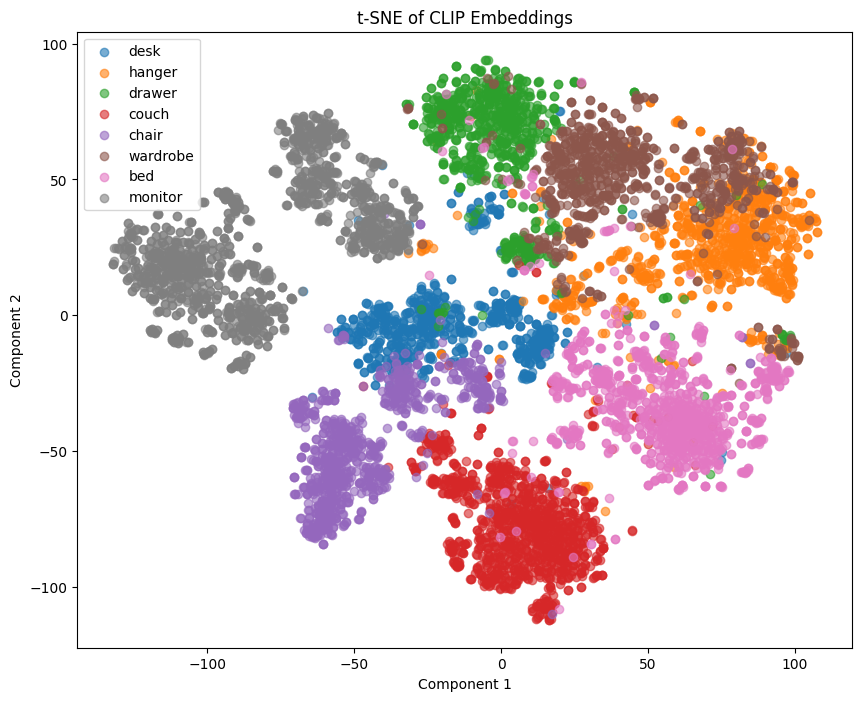

In [28]:
# Concatenate all embeddings
all_embeddings = np.vstack(all_embeddings)

# Apply t-SNE
tsne_results = get_embeddings_tsne(all_embeddings)

# Visualize
visualize_tsne(tsne_results, image_labels)